In [3]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_productivity = "all"

In [6]:
from sklearn.datasets import make_swiss_roll


def get_swiss_roll(samples=100):
    X, _ = make_swiss_roll(n_samples=samples, noise=0.1, random_state=42)
    return X

## Kernel PCA

In [7]:
X = get_swiss_roll()
X.shape

(100, 3)

In [12]:
from matplotlib import pyplot as plt

(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)


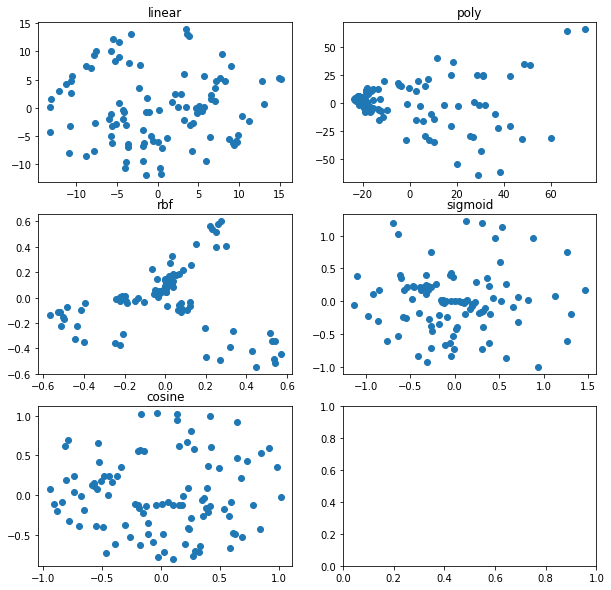

In [28]:
from sklearn.decomposition import KernelPCA

kernels = ["linear", "poly", "rbf", "sigmoid", "cosine"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for k, ax in zip(kernels, axes.ravel()):
    kpca = KernelPCA(n_components=2, kernel=k, gamma=0.04)
    X_trans = kpca.fit_transform(X)
    print(X_trans.shape)
    ax.scatter(X_trans[:, 0], X_trans[:, 1])
    ax.set_title(k)

## Hyperparameter tuning with Kernel PCA

First approach is to make a pipeline along with some model and then find the best parameters for pca that fits the pipeline.

In [30]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features=10, n_informative=7, n_redundant=3, random_state=42)

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_trans = pca.fit_transform(X)
X_trans.shape

(100, 6)

In [32]:
pca.explained_variance_

array([25.79316029, 10.89571441,  6.73997572,  5.60045132,  2.53717671,
        1.99467522])

In [33]:
pca.explained_variance_ratio_

array([0.47086822, 0.19890721, 0.12304193, 0.10223929, 0.04631755,
       0.03641388])

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

pca_tuning_pipeline = Pipeline(
    [("kpca", KernelPCA(n_components=6)), ("log_reg", LogisticRegression())]
)

params = {"kpca__kernel": ["rbf", "sigmoid"], "kpca__gamma": [0.01, 0.1, 0.5, 1.0]}

cv_strategry = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs_cv = GridSearchCV(pca_tuning_pipeline, params, cv=cv_strategry, scoring="roc_auc", n_jobs=-1)

gs_cv.fit(X, y)
gs_cv.best_params_, gs_cv.best_score_

({'kpca__gamma': 0.01, 'kpca__kernel': 'rbf'}, 0.7577133794694347)

second approach is to find the parameters that result in the minimum reconstruction error


In [44]:
# understanding reconstruction error calculation
import numpy as np

rng = np.random.default_rng(seed=42)
X = rng.integers(1, 100, size=(3, 3), endpoint=True)
X_preimage = np.round(X + rng.normal(size=(3, 3)), decimals=1)

X, X_preimage

(array([[ 9, 78, 66],
        [44, 44, 86],
        [ 9, 70, 21]]),
 array([[ 7.7, 78.1, 65.7],
        [44. , 43.1, 86.9],
        [ 9.8, 70.1, 22.1]]))

In [45]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

0.5855555555555564

In [47]:
# Now I will try to calculate the mean squared error myself
# subtract two matrices, square every element in the result of the subtraction
# Then take the mean of all the elements in the matrix
X_sub = X - X_preimage
X_dist = X_sub ** 2  # broadcasting operation
X_dist.mean()

0.5855555555555563

In [56]:
# This is another approach but this would not yield same results as above.
# Now let me try to consider these matrices as set of column vectors
# and then try to find the euclidean distance between the corresponding
# column vectors in the matrices and taken the average of the distances
X_dist = (X - X_preimage) ** 2
X_dist

array([[1.69, 0.01, 0.09],
       [0.  , 0.81, 0.81],
       [0.64, 0.01, 1.21]])

In [58]:
vec_dist = X_dist.sum(axis=0)
vec_dist

array([2.33, 0.83, 2.11])

In [59]:
vec_dist = np.sqrt(vec_dist)
vec_dist
vec_dist.mean()

1.2966870049317338

From the above implementations, mean_squared_error on two matrices is different f